In [5]:
# !usr/bin/python
# -*- encoding: utf-8 -*-
# Project: Softmax from scratch
# Author: Tracy Tao
# Date: 2022/04/10

import torch
from IPython import display
from d2l import torch as d2l
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [6]:
num_inputs, num_outputs = 784, 10
W = torch.normal(0, 0.01, size = (num_inputs, num_outputs), requires_grad = True) # W 784*10
b = torch.zeros(num_outputs, requires_grad = True) # bias 1*10
# Y = XW + b 1*784*10 + 1 *10 -> 1 *10

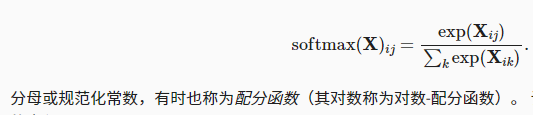

In [7]:
def softmax(X):
    '''
    :param X: inputs
    function: softmax regulate inputs
    return y_hat
    '''
    return torch.exp(X) / torch.exp(X).sum(1, keepdim = True) # 1 - 行汇总； 0 - 列汇总

In [8]:
def net(X):
    '''
    :param X: inputs
    function: build softmax model
    return y_hat
    '''
    # 直接调用定义的softmax函数,对线性回归模型输出的结果o_hat进行规范化
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W + b)) # X.reshape（-1, W.shape[0])展平

In [9]:
def log_cross_entropy(y_hat, y):
    '''
    :param y_hat: softmax result:
    :param y: index
    function: loss function
    return log-based cross entropy loss
    '''
    return -torch.log(y_hat[range(len(y_hat)), y])

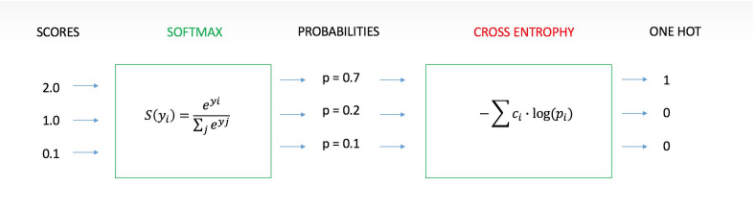

In [10]:
def acc(y_hat, y): #@save
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: # 如果y_hat维度大于一并且列数大于1
        y_hat = y_hat.argmax(axis =1) # y_hat取列向量中概率最大化作为预测值
    cmp = y_hat.type(y.dtype) == y # 判断将y_hat的数据类型转换为与y的数据类型一致
    return float(cmp.type(y.dtype).sum()) # 计算1的个数，统计正确预测数量

In [11]:
def acc_rate(y_hat, y):
    '''
    计算预测正确率
    '''
    return acc(y_hat, y) / len(y)

In [12]:
def evaluate_acc( net, data_iter): 
    '''
    计算指定数据集上的精度
    '''
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(acc(net(X),y), y.numel())
    return metric[0] / metric[1] #预测正确率

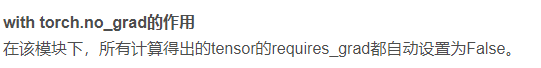

In [13]:
class Accumulator: 
    '''在n个变量上累加'''
    def __init__(self, n):
        '''initialize'''
        self.data = [0.0] *n 
    def add(self, *args):
        '''累加'''
        self.data = [a + float(b) for a,b in zip(self.data, args)]
    def reset(self):
        '''清零'''
        self.data = [0.0] *len(self.data)
    def __getitem__(self, idx):
        '''indexing value'''
        return self.data[idx]

In [14]:
def train_epoch_ch3(net, train_iter, loss, updater):
    '''
    :param net: softmax model
    :param train_iter: training set
    :param loss: log-based log cross entropy loss function
    :param updater: optimizer
    return: 平均损失，平均准确度
    '''
    if isinstance(net, torch.nn.Module): # 如果net是torch.nn.Module的实例
        net.train() # 设置训练模式
    metric = Accumulator(3) # 训练损失总和、训练准确度总和、样本数
    for X,y in train_iter:
        y_hat = net(X) # 计算softmax输出值
        l = loss(y_hat, y) # 就是损失
        if isinstance(updater, torch.optim.Optimizer): # 如果updater是torch.optim.Optimizer的实例
            updater.zero_grad() # 初始化梯度，以0.0占位
            l.mean().backward() # 计算平均损失的梯度
            updater.step() # 根据步长更新参数
        else:
            l.sum().backward() # 计算总损失的梯度
            updater(X.shape[0]) # 对X的行进行更新
        metric.add(float(l.sum()), acc(y_hat, y), y.numel()) # 训练损失总和、训练准确度总和、样本数
    return metric[0]/metric[2], metric[1]/metric[2] # 计算平均损失，平均准确度

In [2]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    '''
    :param net: softmax model
    :param train_iter: training set
    :param test_iter: test set
    :param loss: log-based log cross entropy loss function
    :param num_epochs: epochs
    :param updater: optimizer
    '''
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs): # 训练epoch次
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater) # 训练集平均损失和平均精确度
        test_acc = evaluate_acc(net, test_iter) # 测试集正确率
    train_loss, train_acc = train_metrics
    assert train_loss <0.5, train_loss # 设置训练集损失阈值
    assert train_acc <= 1 and train_acc > 0.7, train_acc # 设置训练集准确率阈值
    assert test_acc <= 1 and test_acc > 0.7, test_acc # 设置测试集阈值

In [3]:
lr = 0.1
def updater(batch_size):
    '''随机梯度下降优化器'''
    return d2l.sgd([W,b], lr, batch_size)

In [17]:
num_epochs = 10
# train_ch3(net, train_iter, test_iter, log_cross_entropy, num_epochs, updater)

In [18]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

# predict_ch3(net, test_iter)